# Returns Prediction

**Steps:**
1. Data collection and preprocessing: adjusted daily log returns for the 10 stocks from 2012 - 2024
2. Feature engineering
   1. RSI
   2. Volume
   3. Rolling mean and violality
   4. Crude oil prices
   5. GDP
   6. Producer price index for energy
   7. Consumer price index
   8. Inflation rate
   9. Market volatility index
   10. Year, Month, Day, Weekday
3. Modelling: Linear regression, XGBoost, and LSTM
   - Training
   - Validation
   - Testing

## 1. Data Collection and Preprocessing

In [75]:
# 1. Data collection
import yfinance as yf
import pandas as pd
import numpy as np

tickers = ["AAPL", "AMZN", "GOOG", "INTC", "ORCL", "XOM", "CVX", "COP", "HES", "OXY"]

start_date = "2012-01-01"
end_date = "2024-12-31"
df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)[['Adj Close', 'Volume']]
# check missing values
df.isnull().sum()

[*********************100%***********************]  10 of 10 completed


Price      Ticker
Adj Close  AAPL      0
           AMZN      0
           COP       0
           CVX       0
           GOOG      0
           HES       0
           INTC      0
           ORCL      0
           OXY       0
           XOM       0
Volume     AAPL      0
           AMZN      0
           COP       0
           CVX       0
           GOOG      0
           HES       0
           INTC      0
           ORCL      0
           OXY       0
           XOM       0
dtype: int64

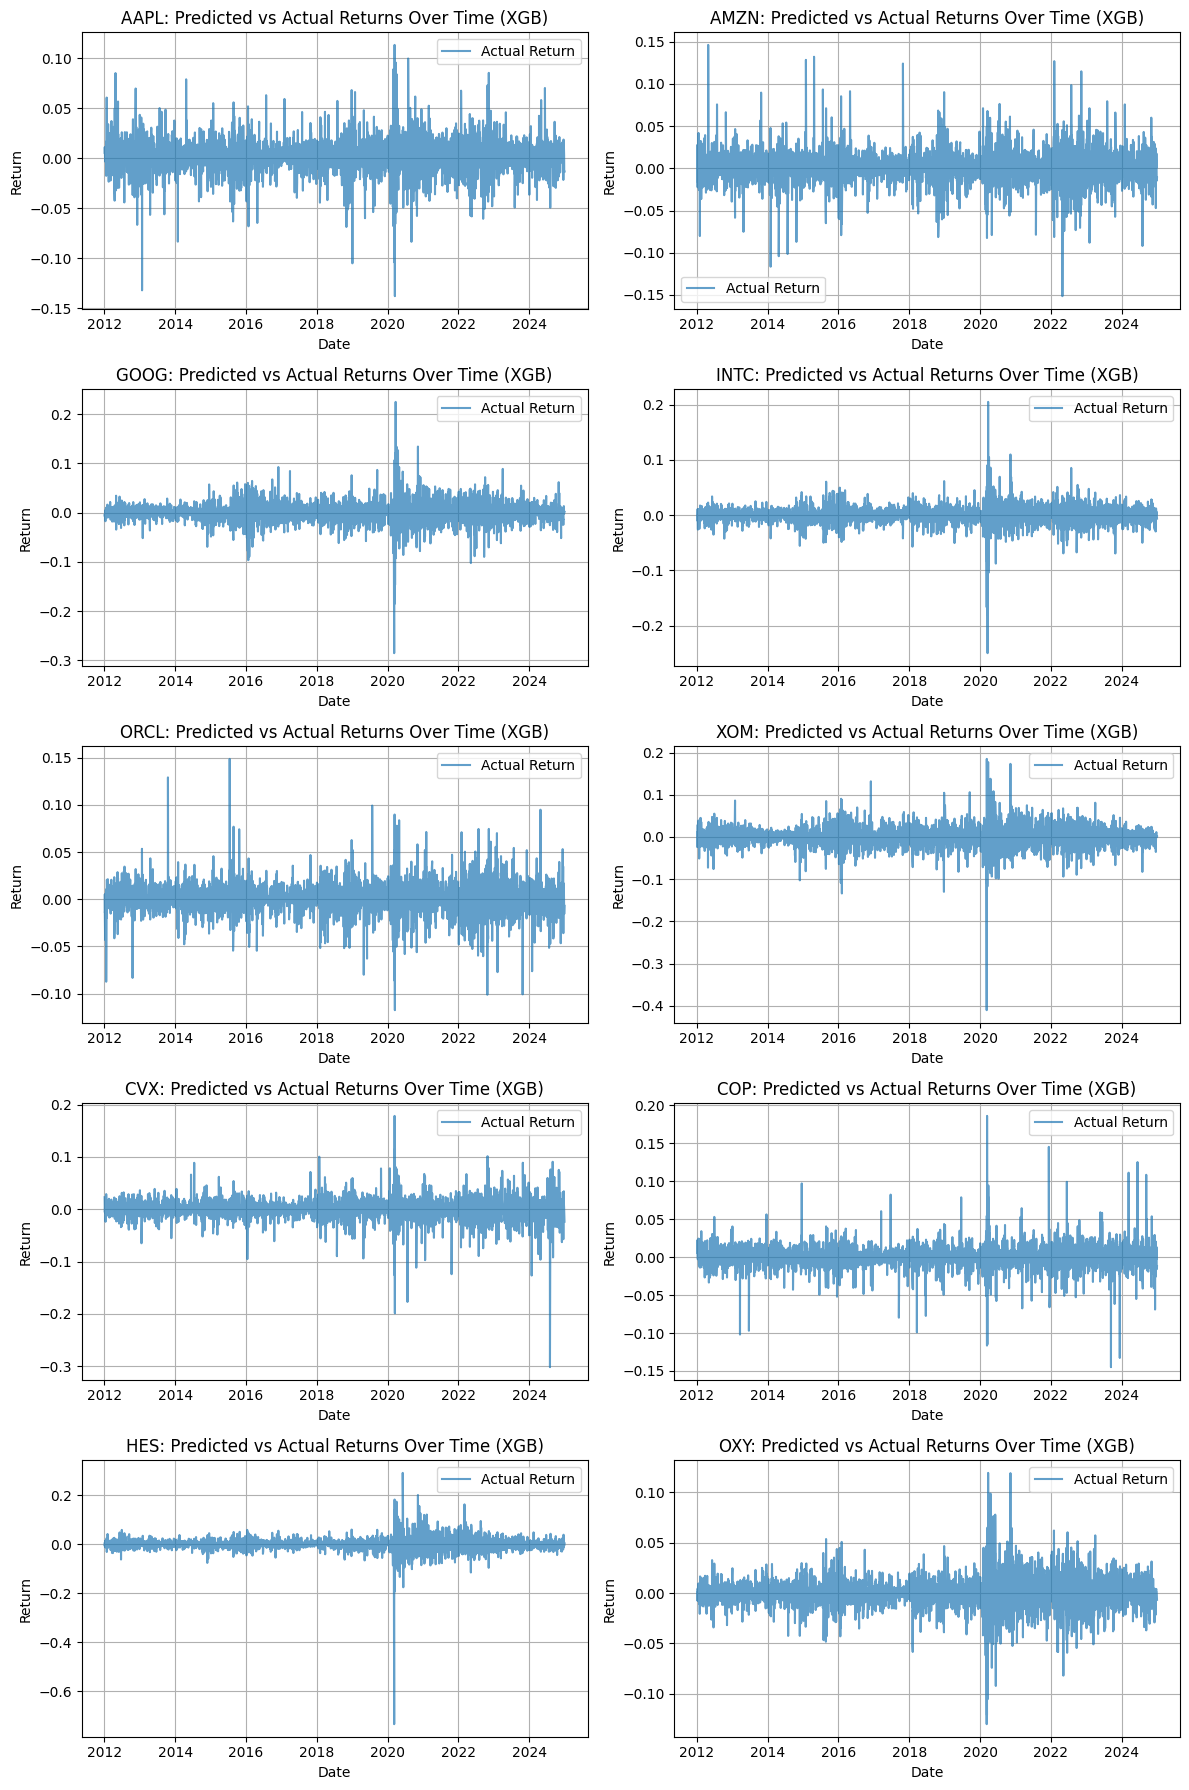

In [ ]:
import matplotlib.pyplot as plt

log_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

fig, axes = plt.subplots(5, 2, figsize=(12, 18)) 

for i, stock in enumerate(log_returns.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(log_returns.index, log_returns[stock], label="Actual Return", alpha=0.7)
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    ax.set_title(f"{tickers[i]}:Actual Returns Over Time")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

## 2. Feature Enigneering

In [77]:
# Compute log returns
log_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
#print(log_returns.head(10))

# our target (predicting return at day t+1 using data upon day t)
target_log_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1)).shift(-1)
target_log_returns = target_log_returns.add_suffix("_Target")
#print(target_log_returns.head(10))

# Compute rolling averages and volatility
rolling_windows = [5, 20, 50, 100, 200]
ma_features = []
volatility_features = []

for window in rolling_windows:
    ma_features.append(log_returns.rolling(window=window).mean().add_suffix(f'_MA{window}'))
    volatility_features.append(log_returns.rolling(window=window).std().add_suffix(f'_Volat{window}'))

# Concatenate
log_returns = pd.concat([log_returns] + ma_features + volatility_features, axis=1)

df1 = pd.concat([target_log_returns, log_returns], axis=1)

# Compute RSI
def compute_rsi(data, window=14):
    """Computes Relative Strength Index (RSI)."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

rsi_features = [compute_rsi(df1[ticker]).rename(f"RSI_{ticker}") for ticker in tickers]
df1 = pd.concat([df1] + rsi_features, axis=1)

# Volume
volume_ma_features = [df['Volume'].rolling(window=window).mean().add_suffix(f"_Volume_{window}") for window in rolling_windows]
df = pd.concat([df] + volume_ma_features, axis=1)

# Merge log returns with volume features
final_stock_data = df1.join(df)
# parse the data column
final_stock_data['Year'] = final_stock_data.index.year
final_stock_data['Month'] = final_stock_data.index.month
final_stock_data['Day'] = final_stock_data.index.day
final_stock_data['Weekday'] = final_stock_data.index.weekday  # 0 = Monday, 6 = Sunday
# parse column names
final_stock_data.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in final_stock_data.columns]


In [78]:
final_stock_data.to_csv("featured_data.csv")
final_stock_data.shape

(3269, 204)

In [79]:
# external data
import pandas_datareader.data as web

# Fetch macro metrics
oil_prices = web.DataReader('DCOILWTICO', 'fred', start_date, end_date)  # WTI Crude Oil
gdp = web.DataReader('GDP', 'fred', start_date, end_date)  # GDP Growth
ppi_energy = web.DataReader('PPIENG', 'fred', start_date, end_date)  # Producer Price Index for Energy
cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)  # Consumer Price Index
vix = web.DataReader('VIXCLS', 'fred', start_date, end_date)  # Market Volatility Index
inflation = web.DataReader('T10YIE', 'fred', start_date, end_date)  # 10-Year Breakeven Inflation Rate

macro_data = oil_prices.join([gdp, ppi_energy, cpi, vix, inflation])
macro_data.columns = ['Oil_Price', 'GDP', 'PPI_Energy', 'CPI', 'VIX', "Infation_Rate"]
# fill forward for missing values since some metrics are not reported daily
macro_data.ffill(inplace=True) 

# merge with stock data and drop NA
final_df = final_stock_data.join(macro_data)
final_df.dropna(inplace=True)
final_df.to_csv("final_data.csv")


In [80]:
final_df.shape

(3068, 210)

## Modelling

Before we start the actually modelling, let's normalize the data and split the training and testing set.

In [81]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# split
X_train = final_df.loc["2012-01-01":"2022-12-31", final_df.columns[10:]]
X_test = final_df.loc["2023-01-01":"2024-12-31", final_df.columns[10:]]

Y_train = final_df.loc["2012-01-01":"2022-12-31", final_df.columns[:10]]
Y_test = final_df.loc["2023-01-01":"2024-12-31", final_df.columns[:10]]

# normalization
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Y_train = pd.DataFrame(Y_train_scaled, columns=Y_train.columns, index=Y_train.index)
Y_test = pd.DataFrame(Y_test_scaled, columns=Y_test.columns, index=Y_test.index)

Since we're dealing with time-series data, standard cross-validation doesn't work because of data leakage. An alternative is walk forward CV (using `TimeSeriesSplit` from sklearn) but here, we'll use `Combinatorial Purged CV` introduced by Marcos Lopez de Prado.

In [82]:
from skfolio.model_selection import CombinatorialPurgedCV
from sklearn.model_selection import TimeSeriesSplit

cpcv = CombinatorialPurgedCV(n_folds=4, n_test_folds=2, purged_size = 24, embargo_size = 24)
tscv = TimeSeriesSplit(n_splits=5, gap=24)

### Linear Regression

We'll use linear regression as our baseline model

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
rmse_scores_cpcv = []
rmse_scores_tscv = []

# CPCV
for train_idx, vali_groups in cpcv.split(X_train):
    for test_idx in vali_groups:
        # Convert indices to 1D numpy arrays
        train_idx = np.array(train_idx).flatten()
        vali_idx = np.array(test_idx).flatten()

        # Split train/validation data
        X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
        Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

        # Train model
        lm.fit(X_train_1, Y_train_1)

        # Predict and evaluate
        predictions = lm.predict(X_vali)
        
        rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
        rmse_scores_cpcv.append(rmse)

# walk forward cv
for train_idx, vali_idx in tscv.split(X_train):
    # Split train/validation data
    X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
    Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

    # Train model
    lm.fit(X_train_1, Y_train_1)

    # Predict and evaluate
    predictions = lm.predict(X_vali)
    
    rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
    rmse_scores_tscv.append(rmse)

In [84]:
print("Linear Rregression:")
print("Overall RMSE for TSCV:" , np.mean(rmse_scores_tscv))
print("RMSE across fold")
for i in rmse_scores_tscv:
    print(i)

print("\n Overall RMSE for CPCV:" , np.mean(rmse_scores_cpcv))
print("RMSE across fold")
for i in rmse_scores_cpcv:
    print(i)

Linear Rregression:
Overall RMSE for TSCV: 11.746831447485153
RMSE across fold
[31.10052686 35.40498296  6.52785122 13.25674598 33.49395827 16.17350392
 28.48937769 14.85463701 23.49318576 14.75627653]
[10.48025798 11.33068147 14.98468395 11.33261082  8.30536124 16.79316187
  3.4941339  10.67105159  4.54883327 15.75847199]
[ 6.35681597  7.64759126  3.79252357  4.23446349  5.4507518   2.09306292
 14.50226394  9.56054684  1.83234886  2.49703186]
[40.10915802 11.90613077  9.42571554  4.93588518 16.8940046   9.84596541
 42.1270665   8.03453725  4.59553879  6.37553968]
[9.2515045  4.07827833 3.53164722 3.88212233 6.4353151  3.06977603
 4.65285101 7.65265735 5.31558503 2.00459895]

 Overall RMSE for CPCV: 15.546585515816048
RMSE across fold
[30.17092443 29.30328323 24.66833496 27.88358751 31.30092521 29.1491978
 30.95314265  8.25821708 53.50935698 58.33443967]
[ 9.0382893   8.88462955  5.81626148  5.71855028  9.51674981  4.23911482
  9.72080931 16.67160588  3.6092672   5.77581087]
[28.458217

RMSE:
AAPL_Target:0.046229670532186636
AMZN_Target:0.08490892058828932
COP_Target:0.06605219833233952
CVX_Target:0.09107888421503094
GOOG_Target:0.03951100230311141
HES_Target:0.045084044997268445
INTC_Target:0.10161712166837907
ORCL_Target:0.027010597881019775
OXY_Target:0.06079051028254158
XOM_Target:0.03673510790756726
Overall RMSE: 0.05990180587077339


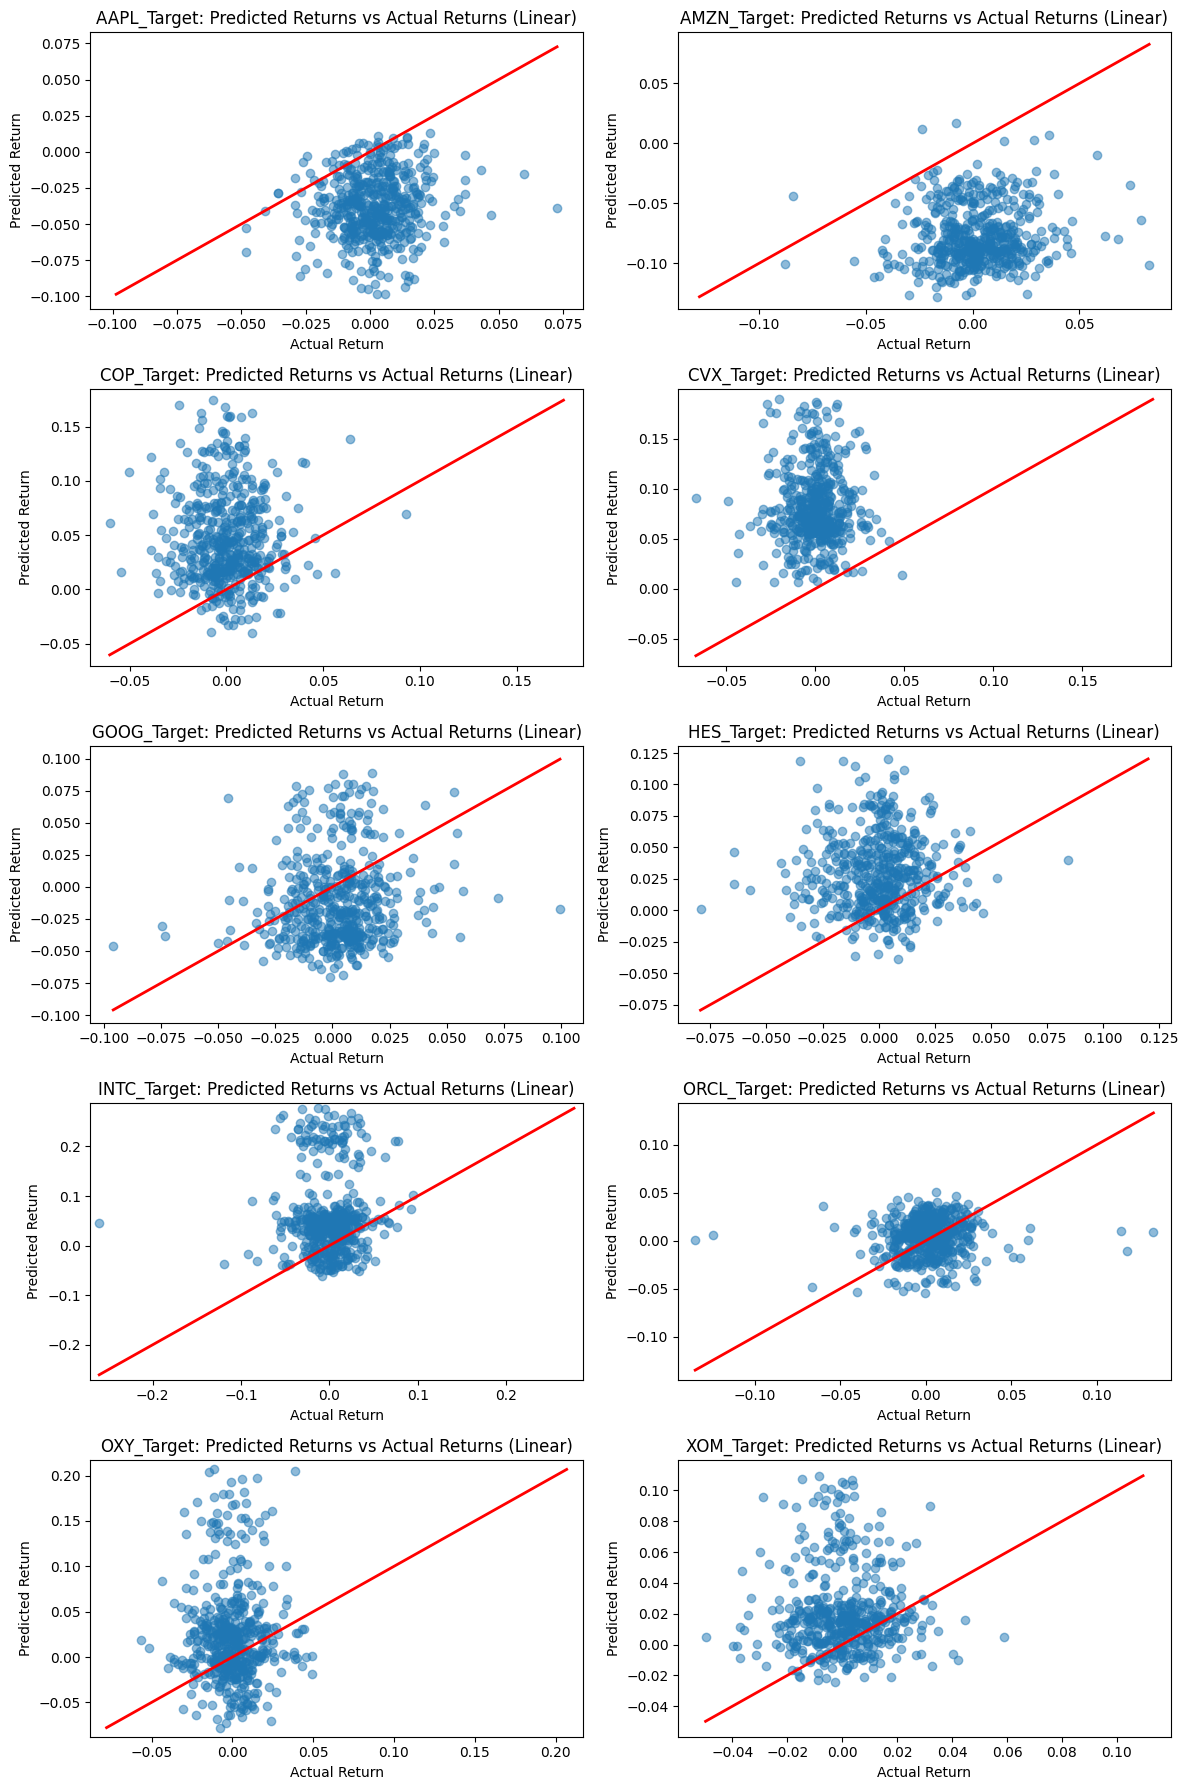

In [85]:
import matplotlib.pyplot as plt

# the final model
lm = LinearRegression()
lm.fit(X_train, Y_train)

# Predict on the test set
predictions = lm.predict(X_test)
# Inverse transformation
predictions_log = scaler_Y.inverse_transform(predictions)
Y_test_log = scaler_Y.inverse_transform(Y_test)
# Convert log returns back to actual percentage returns
predictions_real = (np.exp(predictions_log) - 1) 
Y_test_real = (np.exp(Y_test_log) - 1) 

Y_test_real_df = pd.DataFrame(Y_test_real, columns=Y_test.columns, index=Y_test.index)

rmse = np.sqrt(mean_squared_error(Y_test_real, predictions_real, multioutput='raw_values'))
print("RMSE:")
for i, stock in enumerate(Y_train.columns):
    print(f"{stock}:{rmse[i]}")
print("Overall RMSE:", np.mean(rmse))

# Plot predicted vs actual returns for each of the 10 stocks
fig, axes = plt.subplots(5, 2, figsize=(12, 18)) 

for i, stock in enumerate(Y_train.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.scatter(Y_test_real_df[stock], predictions_real[:, i], alpha=0.5)
    min_val = min(Y_test_real_df[stock].min(), predictions_real[:, i].min())
    max_val = max(Y_test_real_df[stock].max(), predictions_real[:, i].max())
    ax.set_xlim(min_val-0.01, max_val+0.01)
    ax.set_ylim(min_val-0.01, max_val+0.01)
    ax.plot([min_val, max_val], [min_val, max_val], 'r', lw=2)
    ax.set_xlabel("Actual Return")
    ax.set_ylabel("Predicted Return")
    ax.set_title(f"{stock}: Predicted Returns vs Actual Returns (Linear)")
plt.tight_layout()


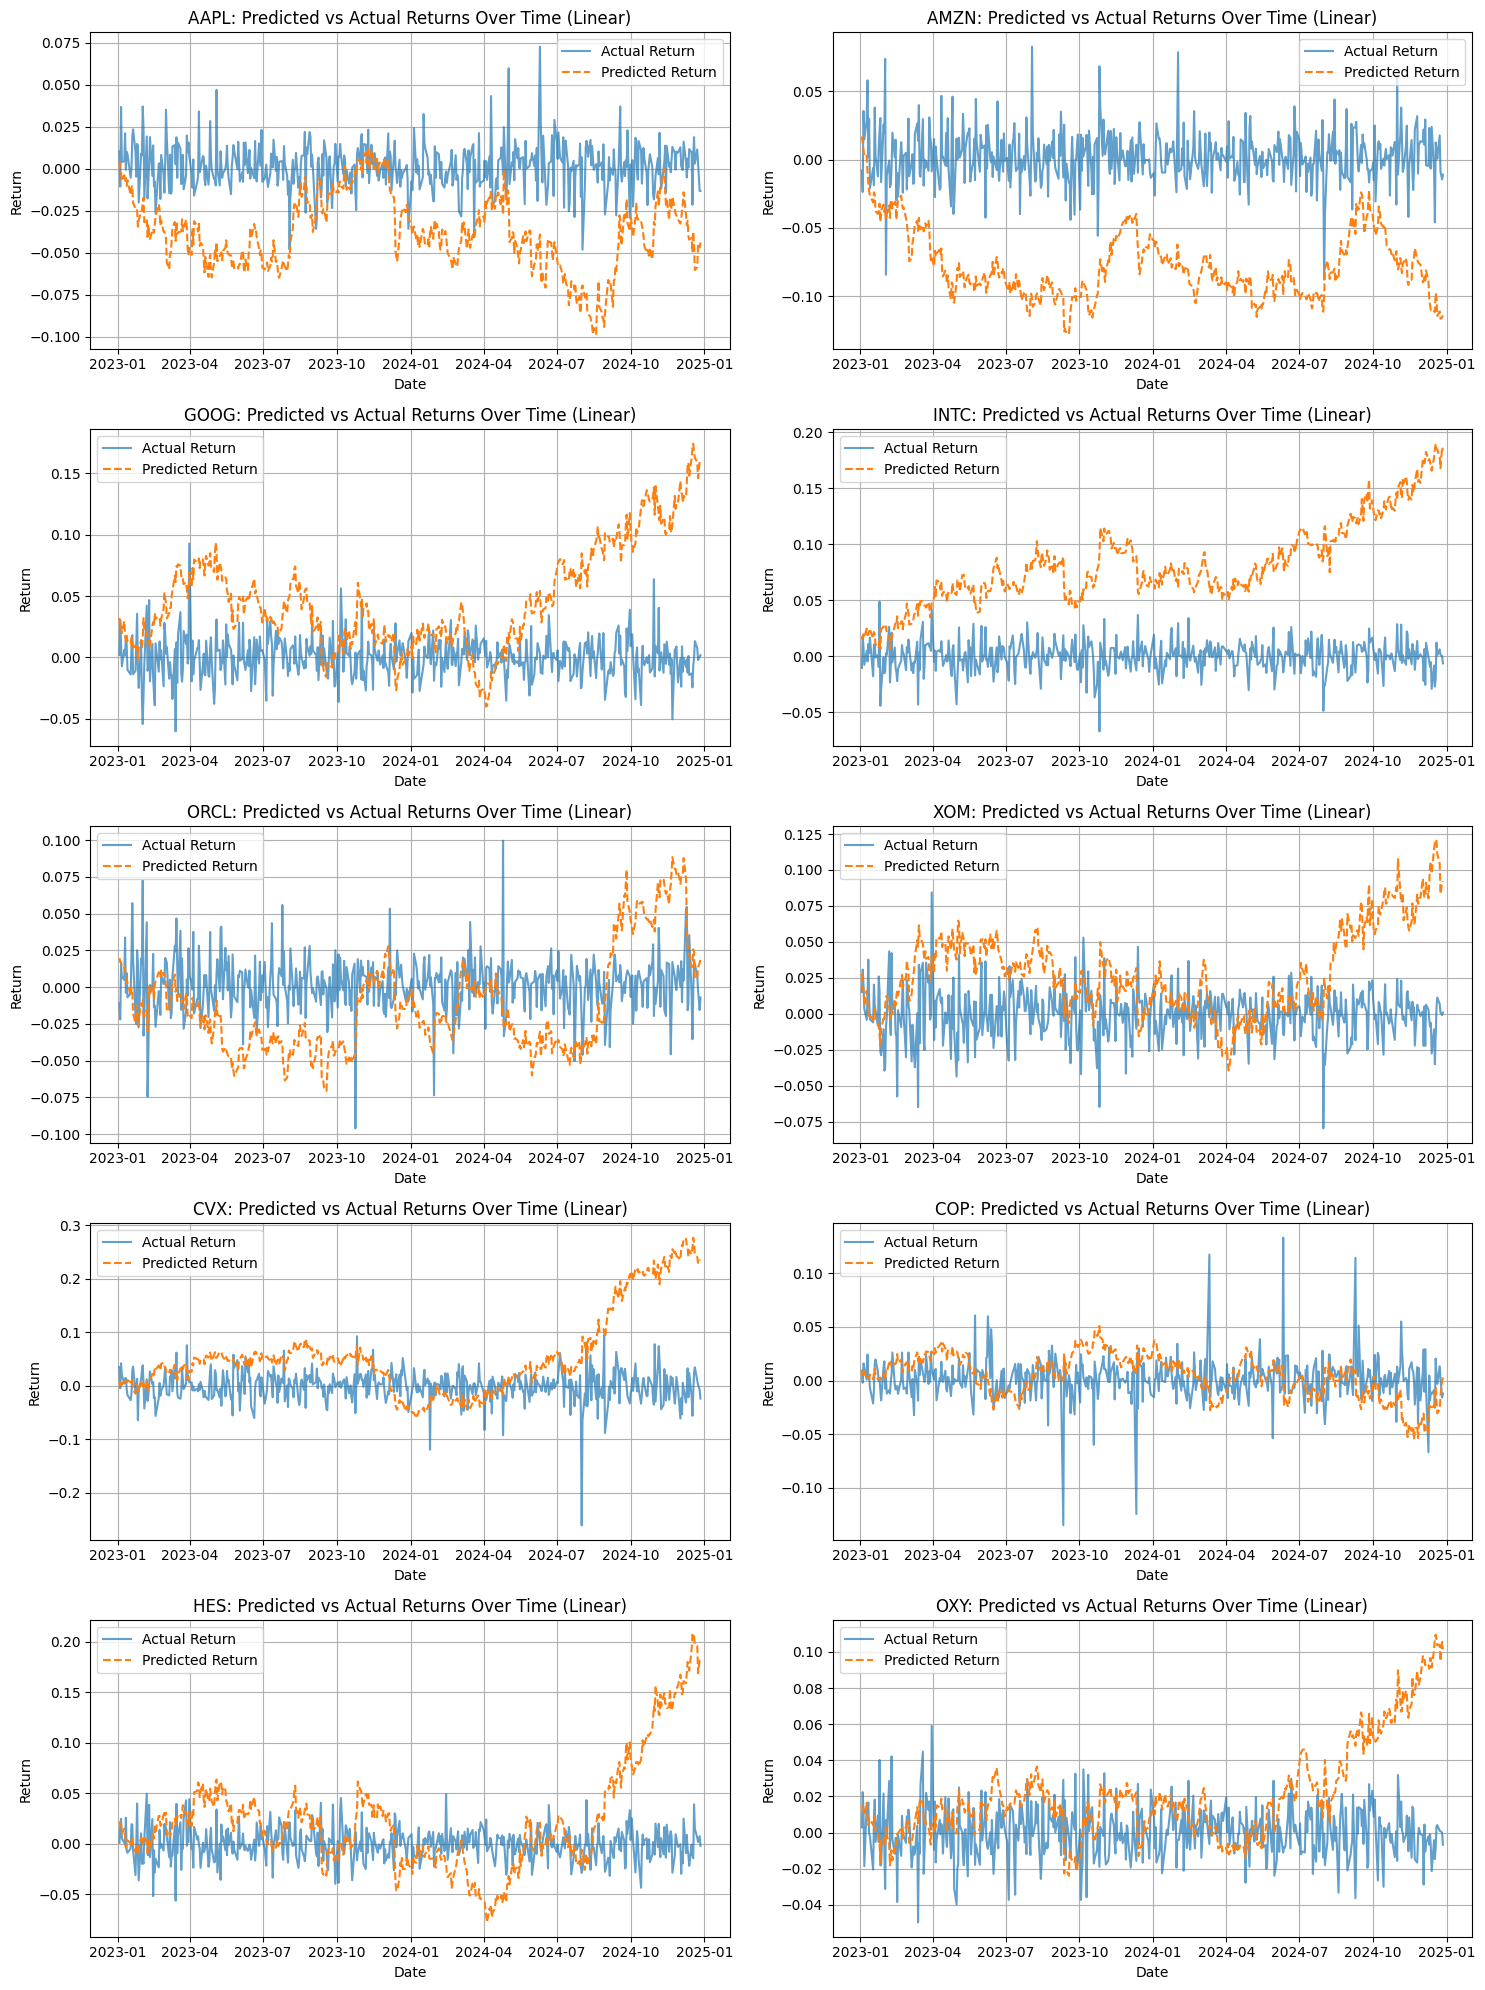

In [86]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, stock in enumerate(Y_train.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(Y_test_real_df.index, Y_test_real_df[stock], label="Actual Return", alpha=0.7)
    ax.plot(Y_test_real_df.index, predictions_real[:, i], label="Predicted Return", linestyle="--")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    ax.set_title(f"{tickers[i]}: Predicted vs Actual Returns Over Time (Linear)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

### XGBoost

The second model we'll build is XGboosting.

In [87]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor


xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
rmse_scores_cpcv = []
rmse_scores_tscv = []

# CPCV
for train_idx, vali_groups in cpcv.split(X_train):
    for test_idx in vali_groups:
        # Convert indices to 1D numpy arrays
        train_idx = np.array(train_idx).flatten()
        vali_idx = np.array(test_idx).flatten()

        # Split train/validation data
        X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
        Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

        # Train model
        xgb.fit(X_train_1, Y_train_1)

        # Predict and evaluate
        predictions = xgb.predict(X_vali)
       
        rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
        rmse_scores_cpcv.append(rmse)

# walk forward cv
for train_idx, vali_idx in tscv.split(X_train):
    # Split train/validation data
    X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
    Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

    # Train model
    xgb.fit(X_train_1, Y_train_1)
    predictions = xgb.predict(X_vali)
  
    rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
    rmse_scores_tscv.append(rmse)


In [88]:
print("XGboost:")
print("Overall RMSE for TSCV:" , np.mean(rmse_scores_tscv))
for i in rmse_scores_tscv:
    print(i)

print("\n Overall RMSE for CPCV:" , np.mean(rmse_scores_cpcv))
for i in rmse_scores_cpcv:
    print(i)

XGboost:
Overall RMSE for TSCV: 1.1777334
[1.2268173  1.1277931  0.9865137  0.99053353 1.7125874  0.9566172
 0.9046045  1.1840012  0.57286036 0.8781011 ]
[1.1047086  1.3313063  1.0094311  0.8358016  0.81543064 1.5576841
 0.7812393  1.1522733  0.52964145 0.845975  ]
[1.0878545  1.0055947  0.83268595 0.7831446  1.0129966  0.91643596
 1.0340137  1.0126344  0.5639377  0.7930294 ]
[1.4561814 1.1081687 1.6953868 1.8683316 1.4948013 1.6643902 2.1818457
 1.4560533 1.9753925 1.7120286]
[1.1537364 1.3223436 1.1452577 1.1065605 1.3256195 1.1221694 1.3344119
 1.4506758 1.461515  1.305556 ]

 Overall RMSE for CPCV: 1.1338336
[0.9566456  1.0910983  0.6633702  0.6549726  0.9850989  0.76572305
 0.80028844 1.0503201  1.1023557  0.67160696]
[0.86489356 0.93756473 0.97520113 0.81768125 1.0615906  1.1096334
 0.89766276 1.0548965  1.3073363  0.844633  ]
[0.93703055 1.0417793  0.6861633  0.6875881  0.9892925  0.71822965
 0.83353436 0.96467966 0.48123187 0.62588906]
[1.1600662 1.054356  1.4479766 1.4361745 1

The fine-tuning step is commented out due to its runtime (about 40 mins)

In [ ]:
# # fine-tuning using Bayesian Optimization
# from bayes_opt import BayesianOptimization

# # objective function
# def xgb_evaluate(n_estimators, learning_rate, max_depth, min_child_weight, subsample):
#     """Objective function for Bayesian Optimization to minimize MSE"""
#     params = {
#         "n_estimators": int(n_estimators),
#         "learning_rate": learning_rate,
#         "max_depth": int(max_depth),
#         "min_child_weight": int(min_child_weight),
#         "subsample": subsample
#     }

#     xgb = MultiOutputRegressor(XGBRegressor(**params, random_state=42))
#     rmse_scores = []

#     for train_idx, vali_idx in tscv.split(X_train):
#         # Split train/validation data
#         X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
#         Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

#         # Train model
#         xgb.fit(X_train_1, Y_train_1)
#         predictions = xgb.predict(X_vali)
    
#         rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
#         rmse_scores.append(rmse)

#     return -np.mean(rmse_scores)  

# # parameter range
# param_bounds = {
#     "n_estimators": (100, 500),
#     "learning_rate": (0.01, 0.1),
#     "max_depth": (3, 10),
#     "min_child_weight": (1, 10),
#     "subsample": (0.5, 1.0)
# }

# optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42, verbose=2)
# optimizer.maximize(n_iter=10)

# # best parameters
# best_params = optimizer.max["params"]

# print("Best Hyperparameters:", best_params)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -1.222    | 0.04371   | 9.655     | 7.588     | 339.5     | 0.578     |
| 2         | -1.133    | 0.02404   | 3.407     | 8.796     | 340.4     | 0.854     |
| 3         | -1.062    | 0.01185   | 9.789     | 8.492     | 184.9     | 0.5909    |
| 4         | -1.171    | 0.02651   | 5.13      | 5.723     | 272.8     | 0.6456    |
| 5         | -1.243    | 0.06507   | 3.976     | 3.629     | 246.5     | 0.728     |
| 6         | -1.138    | 0.02737   | 3.347     | 8.883     | 340.1     | 0.5537    |
| 7         | -1.24     | 0.09999   | 6.379     | 8.063     | 188.0     | 0.6871    |
| 8         | -1.148    | 0.0348    | 8.628     | 8.687     | 183.3     | 0.6859    |
| 9         | -1.119    | 0.01937   | 9.891     | 7.469     | 186.3     | 0.9174    |
| 10        | -1.178    | 0.04402   | 9.992     | 7.66

RMSE:
AAPL_Target:0.018999512064710407
AMZN_Target:0.02274944419612809
COP_Target:0.019002849683513498
CVX_Target:0.015621442131217515
GOOG_Target:0.02216274272981942
HES_Target:0.021383093558754326
INTC_Target:0.030599281709761124
ORCL_Target:0.020761831237501537
OXY_Target:0.02249249142960901
XOM_Target:0.016895461752836922
Overall RMSE 0.021066815049385186


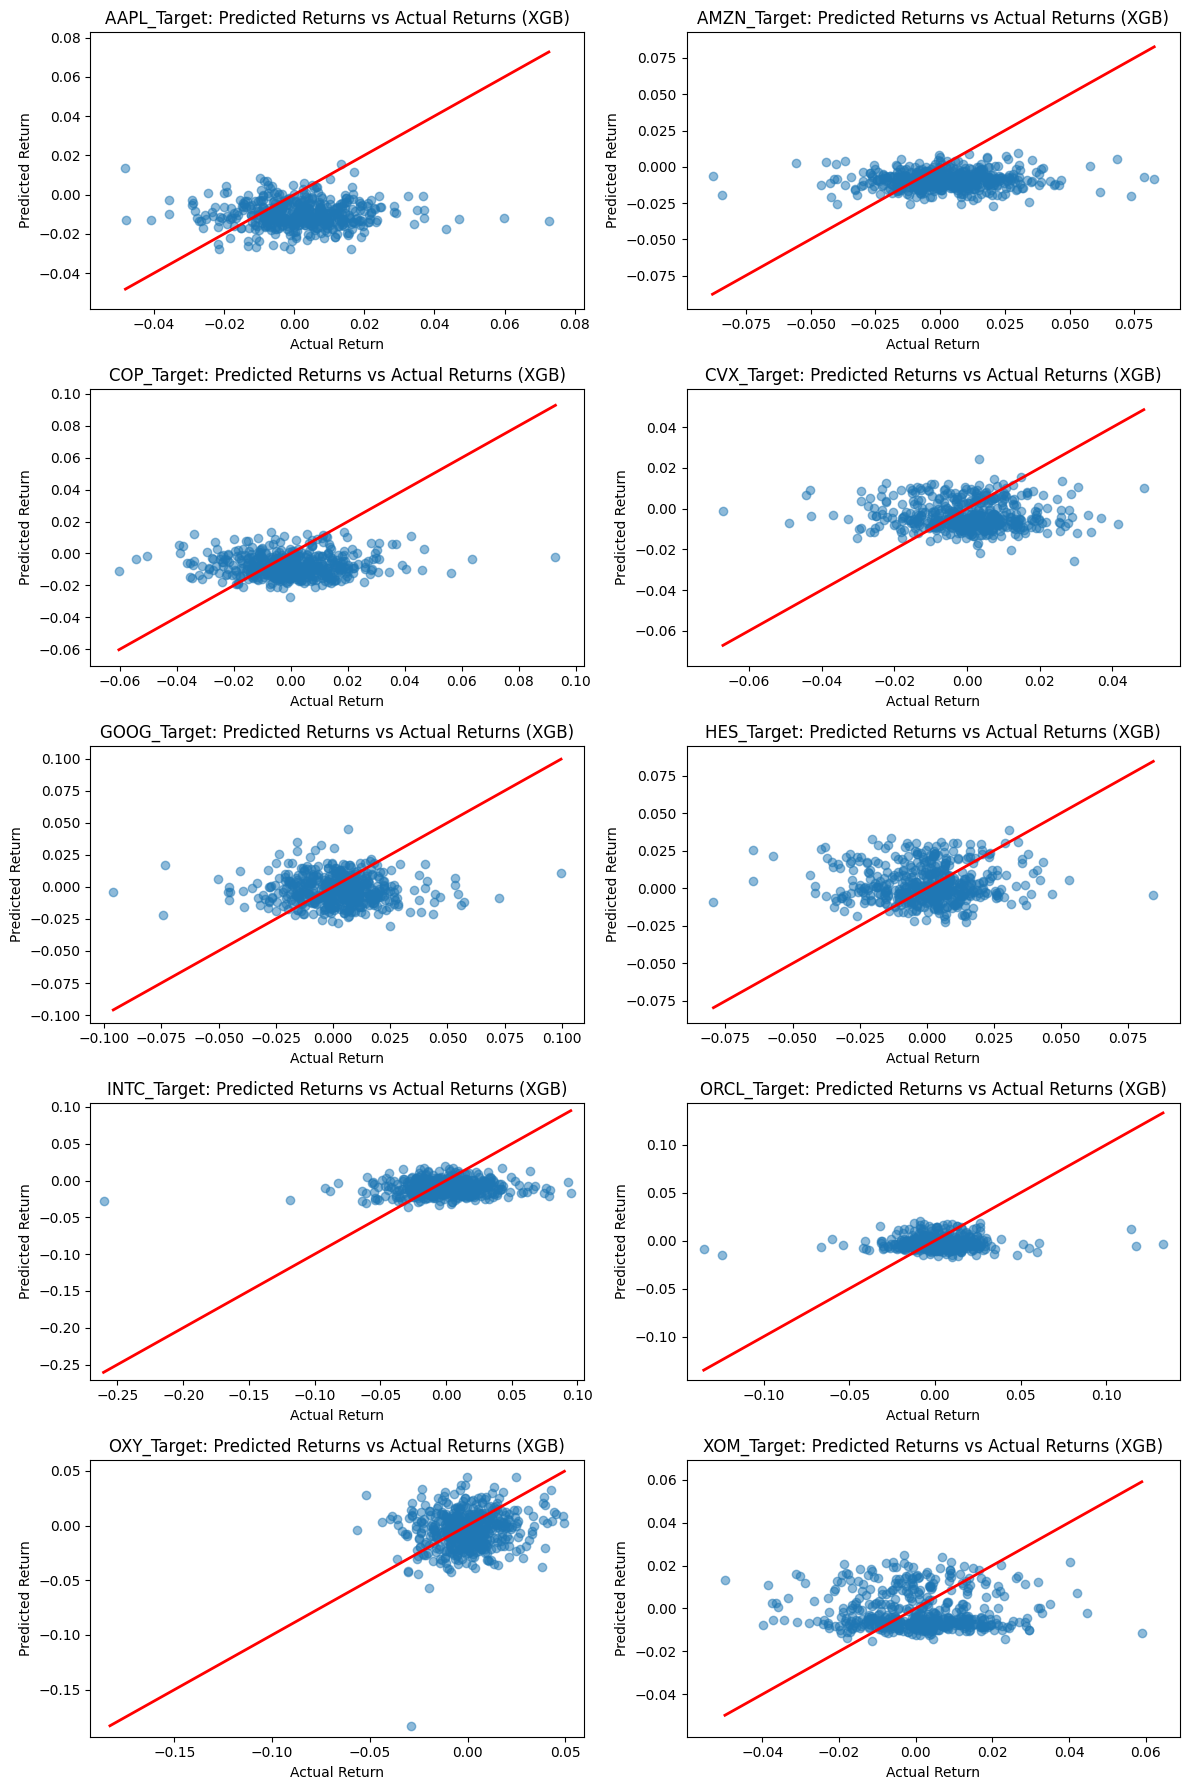

In [ ]:
# Training the final model with best paramaters and test it
# Best Hyperparameters: {'learning_rate': 0.011852604486622221, 'max_depth': 9.78936896513396, 
# 'min_child_weight': 8.491983767203795, 'n_estimators': 184.93564427131048, 'subsample': 0.5909124836035503}

# Train the final model
xgb_final = MultiOutputRegressor(XGBRegressor(n_estimators=185, learning_rate=0.012, max_depth= 10,
                                                min_child_weight= 8, subsample=0.6,  random_state=42))
xgb_final.fit(X_train, Y_train)

# Predict on the test set
predictions = xgb.predict(X_test)
predictions_log = scaler_Y.inverse_transform(predictions)
Y_test_log = scaler_Y.inverse_transform(Y_test)
# Convert log returns back to actual percentage returns
predictions_real = (np.exp(predictions_log) - 1) 
Y_test_real = (np.exp(Y_test_log) - 1) 
rmse = np.sqrt(mean_squared_error(Y_test_real, predictions_real, multioutput='raw_values'))
print("RMSE:")
for i, stock in enumerate(Y_train.columns):
    print(f"{stock}:{rmse[i]}")
print("Overall RMSE", np.mean(rmse))

Y_test_real_df = pd.DataFrame(Y_test_real, columns=Y_train.columns, index=Y_test.index)

# Plot predicted vs actual returns for each of the 10 stocks
fig, axes = plt.subplots(5, 2, figsize=(12, 18)) 

for i, stock in enumerate(Y_train.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.scatter(Y_test_real_df[stock], predictions_real[:, i], alpha=0.5)
    min_val = min(Y_test_real_df[stock].min(), predictions_real[:, i].min())
    max_val = max(Y_test_real_df[stock].max(), predictions_real[:, i].max())
    ax.set_xlim(min_val-0.01, max_val+0.01)
    ax.set_ylim(min_val-0.01, max_val+0.01)
    ax.plot([min_val, max_val], [min_val, max_val], 'r', lw=2)
    ax.set_xlabel("Actual Return")
    ax.set_ylabel("Predicted Return")
    ax.set_title(f"{stock}: Predicted Returns vs Actual Returns (XGB)")
plt.tight_layout()

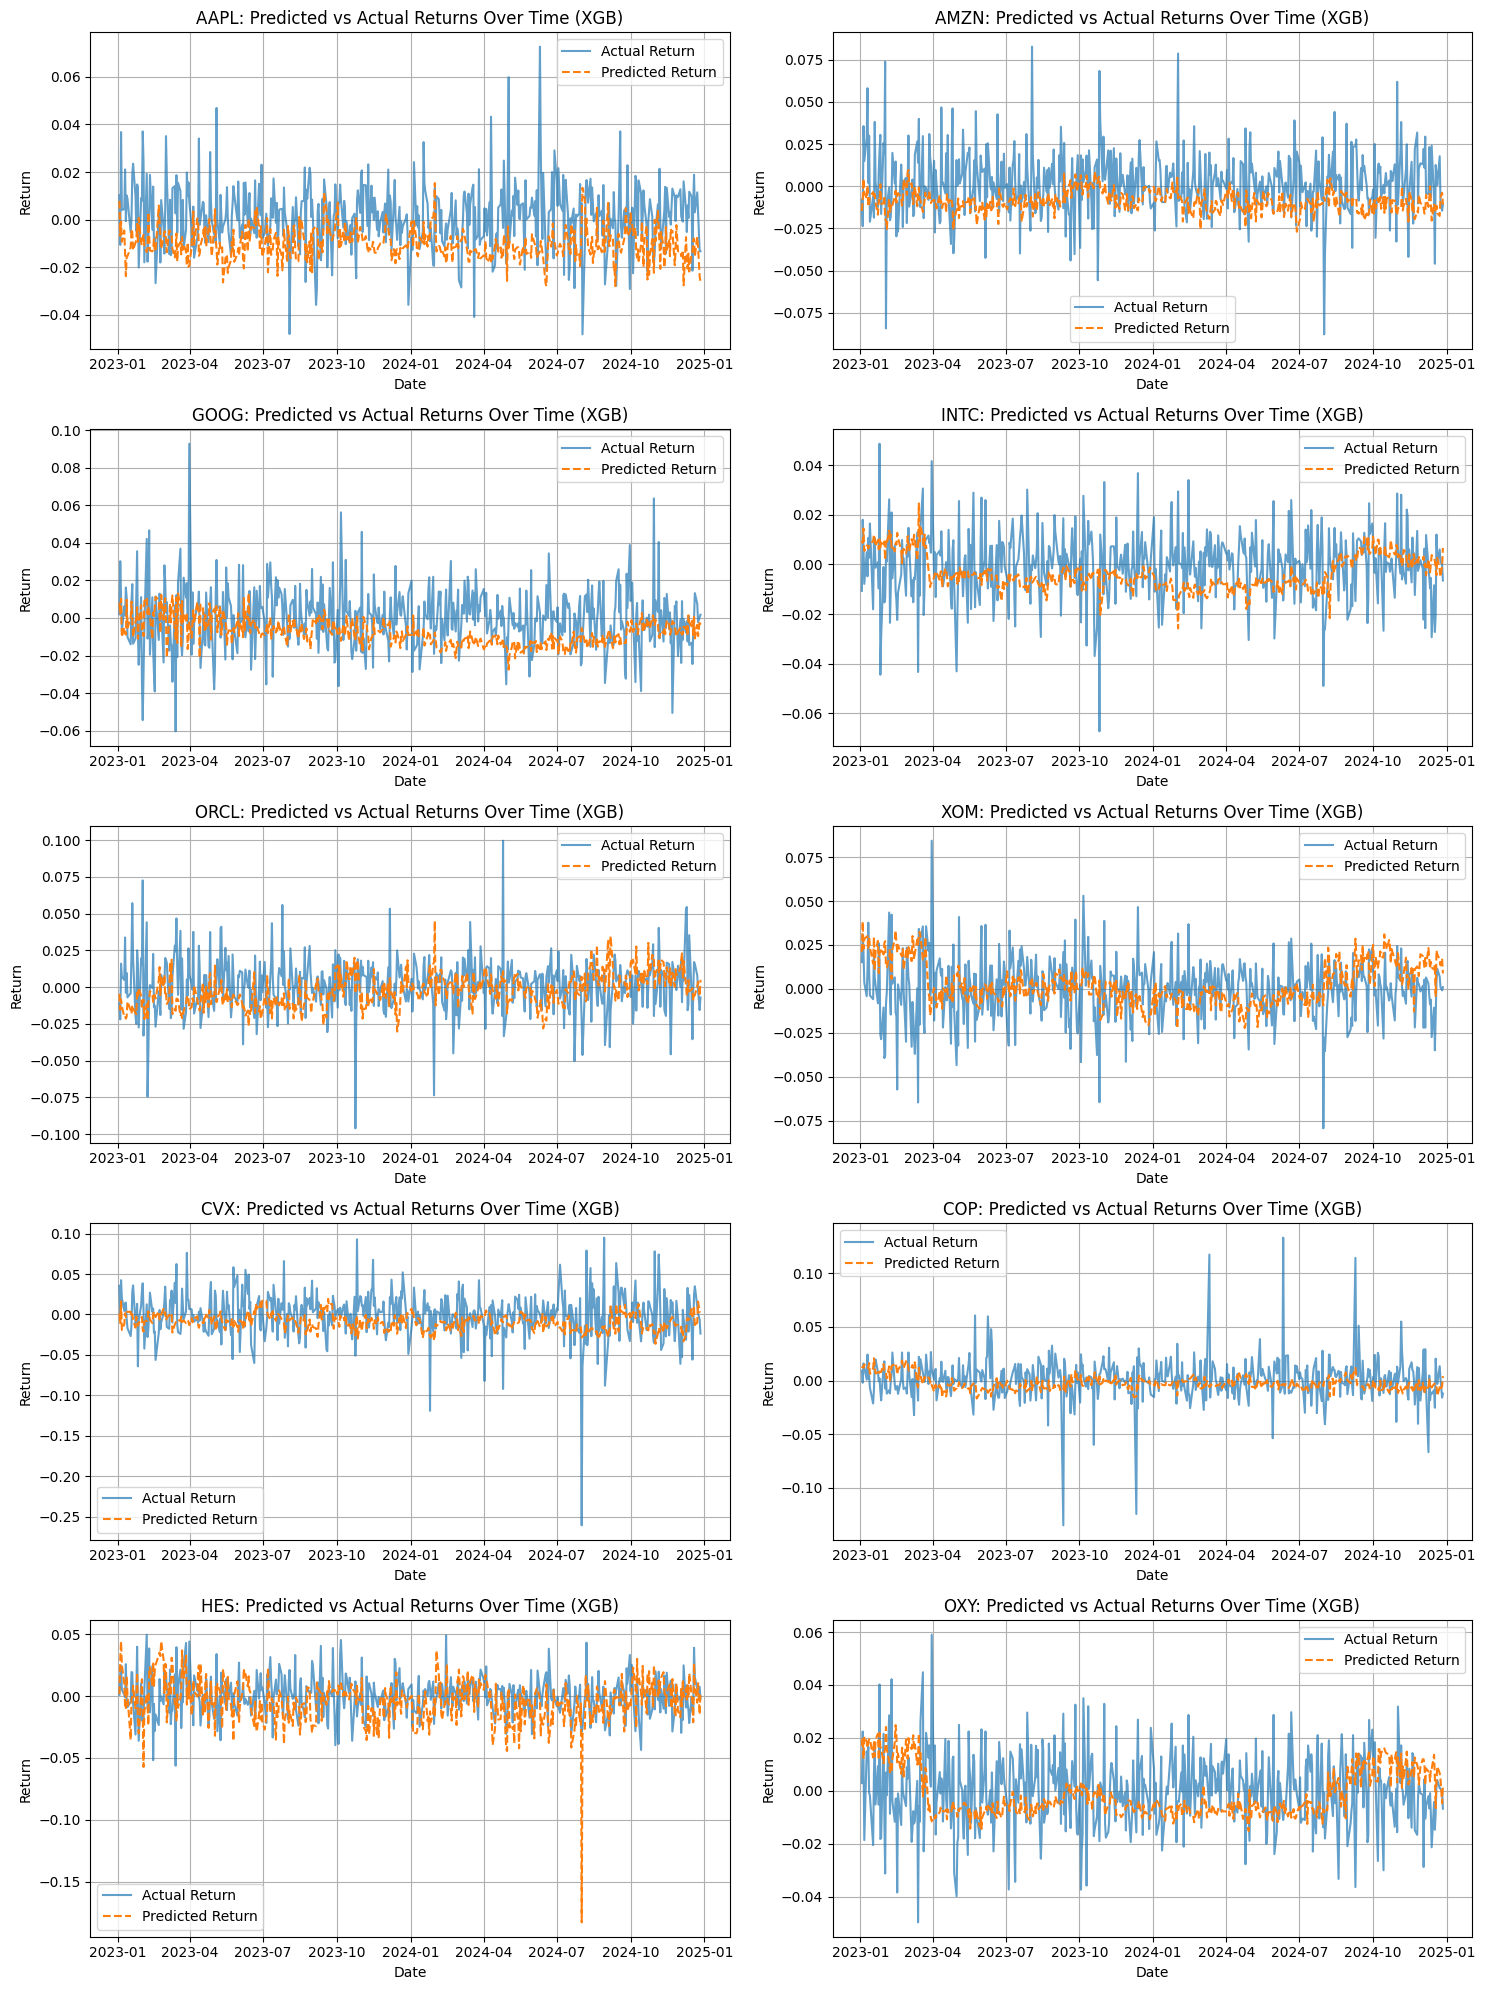

In [93]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, stock in enumerate(Y_train.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(Y_test_real_df.index, Y_test_real_df[stock], label="Actual Return", alpha=0.7)
    ax.plot(Y_test_real_df.index, predictions_real[:, i], label="Predicted Return", linestyle="--")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    ax.set_title(f"{tickers[i]}: Predicted vs Actual Returns Over Time (XGB)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

### LTSM

Finally, we'll build a LTSM model

In [94]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input # type: ignore

# Define LSTM model 
def create_lstm_model(output_units):
    model = Sequential([
        Input(shape=(1, X_train.shape[1])),
        LSTM(units=50, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(units=60, activation='relu', return_sequences=True),
        Dropout(0.3),
        LSTM(units=50, activation='relu'),
        Dropout(0.3),
        Dense(units=output_units)  # multi-output regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

rmse_scores_tscv = []

# Walk-forward CV
for train_idx, vali_idx in tscv.split(X_train):
    X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
    Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

    lstm = create_lstm_model(output_units=Y_train.shape[1])
    X_train_lstm = np.array(X_train_1).reshape((X_train_1.shape[0], 1, X_train_1.shape[1]))
    X_vali_lstm = np.array(X_vali).reshape((X_vali.shape[0], 1, X_vali.shape[1]))
    
    lstm.fit(X_train_lstm, Y_train_1, epochs=50, batch_size=32, verbose=0)
    
    predictions = lstm.predict(X_vali_lstm)
    rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
    rmse_scores_tscv.append(rmse)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [95]:
print("Overall RMSE", np.mean(rmse_scores_tscv))
print(rmse_scores_tscv)

Overall RMSE 1.3598666
[array([0.89496034, 1.1088121 , 0.97829795, 0.95732635, 1.0100226 ,
       0.93907654, 0.860927  , 0.8960981 , 0.57317626, 0.8523049 ],
      dtype=float32), array([1.4153272, 1.3346728, 1.4217821, 1.4489532, 1.230451 , 1.4385372,
       1.0676701, 1.3958466, 0.8762366, 1.2910379], dtype=float32), array([1.0279808 , 1.0827633 , 0.95612067, 0.93035746, 1.0724585 ,
       1.0659165 , 1.0618614 , 1.0085081 , 0.61682874, 0.88975954],
      dtype=float32), array([3.0223393, 2.0404902, 2.5777407, 2.283594 , 2.228422 , 2.5662837,
       1.9453818, 1.8610264, 2.1943898, 2.2002654], dtype=float32), array([1.2416852, 1.3430002, 1.3160797, 1.3628964, 1.3597597, 1.3063565,
       1.2991818, 1.3186151, 1.3428428, 1.4789155], dtype=float32)]


In [ ]:
# # fine-tuning using Bayesian Optimization
# from tensorflow.keras.optimizers import Adam # type:ignore
# from bayes_opt import BayesianOptimization

# # objective function to minimize
# def lstm_evaluate(lstm_units, dropout_rate, learning_rate):
#     lstm_units = int(lstm_units)  
#     # Define LSTM model
#     def create_lstm_model(output_units, lstm_units, dropout_rate, learning_rate):
#         model = Sequential([
#             Input(shape=(1, X_train.shape[1])),
#             LSTM(units=lstm_units, activation='relu', return_sequences=True),
#             Dropout(dropout_rate),
#             LSTM(units=int(lstm_units / 2), activation='relu', return_sequences=True),
#             Dropout(dropout_rate),
#             LSTM(units=int(lstm_units / 2), activation='relu'),
#             Dropout(dropout_rate),
#             Dense(units=output_units) 
#         ])
#         model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#         return model

#     # Walk-forward CV
#     rmse_scores = []
#     for train_idx, vali_idx in tscv.split(X_train):
#         # Split train/validation data
#         X_train_1, X_vali = X_train.iloc[train_idx], X_train.iloc[vali_idx]
#         Y_train_1, Y_vali = Y_train.iloc[train_idx], Y_train.iloc[vali_idx]

#         # Reshape for LSTM (samples, time steps, features)
#         X_train_lstm = np.array(X_train_1).reshape((X_train_1.shape[0], 1, X_train_1.shape[1]))
#         X_vali_lstm = np.array(X_vali).reshape((X_vali.shape[0], 1, X_vali.shape[1]))

#         # Create and train model
#         lstm = create_lstm_model(output_units=Y_train.shape[1],
#                                  lstm_units=lstm_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
#         lstm.fit(X_train_lstm, Y_train_1, epochs=50, batch_size=32, verbose=0)

#         # Make predictions
#         predictions = lstm.predict(X_vali_lstm)
#         rmse = np.sqrt(mean_squared_error(Y_vali, predictions, multioutput='raw_values'))
#         rmse_scores.append(rmse)

#     return -np.mean(rmse_scores)  # Minimize RMSE

# # Parameter search space for Bayesian Optimization
# param_bounds = {
#     "lstm_units": (50, 150),
#     "dropout_rate": (0.1, 0.5),
#     "learning_rate": (0.001, 0.1)
# }

# # Perform Bayesian Optimization
# optimizer = BayesianOptimization(f=lstm_evaluate, pbounds=param_bounds, random_state=42, verbose=2)
# optimizer.maximize(n_iter=10)

# # Get best parameters
# best_params = optimizer.max["params"]
# print("Best Hyperparameters:", best_params)

|   iter    |  target   | dropou... | learni... | lstm_u... |
-------------------------------------------------------------
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
| 1         | -0.9971   | 0.2498    | 0.09512   | 123.2     |
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
| 2         | -0.9988   | 0.3395    | 0.01645   | 65.6      |
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
| 3         | -0.9983   | 0.1232    | 0.08675   | 110.1     |
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
14/14 ━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE:
AAPL_Target:0.035770723503650424
AMZN_Target:0.04005189605170513
COP_Target:0.039047782150233655
CVX_Target:0.03329095028989855
GOOG_Target:0.03720244823672235
HES_Target:0.04686746054231009
INTC_Target:0.04156167318808396
ORCL_Target:0.032561972317567134
OXY_Target:0.041856508462732665
XOM_Target:0.028581472819197547
Overall RMSE: 0.03767928875621014


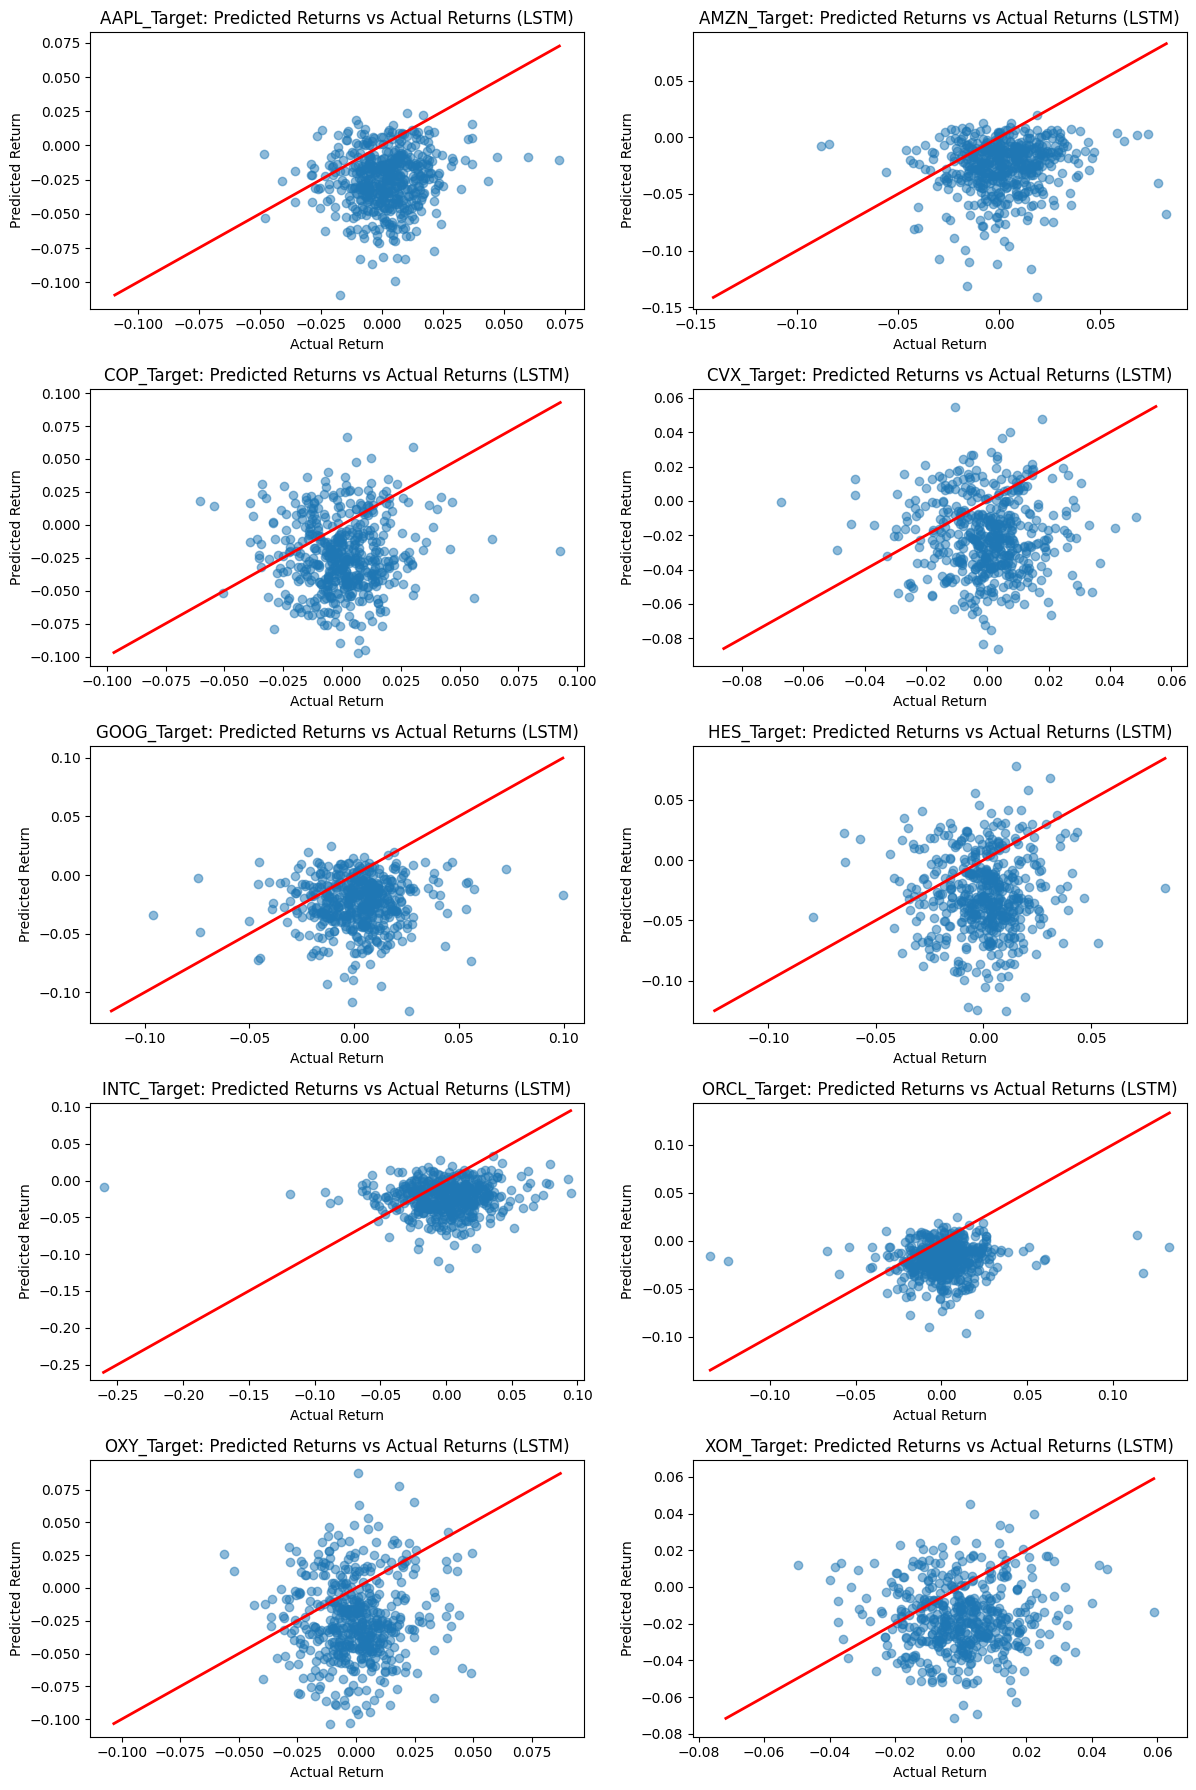

In [104]:
# Train LSTM model with best parameters
# Best Hyperparameters: {'dropout_rate': 0.249816047538945, 'learning_rate': 0.0951207163345817,
#  'lstm_units': 123.1993941811405}

from tensorflow.keras.optimizers import Adam # type:ignore

final_lstm = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(units=124, activation='relu', return_sequences=True),
    Dropout(0.25),
    LSTM(units=int(124 / 2), activation='relu', return_sequences=True),
    Dropout(0.25),
    LSTM(units=int(124 / 3), activation='relu'),
    Dropout(0.25),
    Dense(units=Y_train.shape[1])  # Output layer for multi-output regression
])
final_lstm.compile(optimizer=Adam(learning_rate=0.095), loss='mse')

X_train_lstm = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

final_lstm.fit(X_train_lstm, Y_train, epochs=50, batch_size=32, verbose=0)

# make predictions and convert to real scale
predictions = lstm.predict(X_test_lstm)
predictions_log = scaler_Y.inverse_transform(predictions)
Y_test_log = scaler_Y.inverse_transform(Y_test)
# Convert log returns back to actual percentage returns
predictions_real = (np.exp(predictions_log) - 1) 
Y_test_real = (np.exp(Y_test_log) - 1) 

rmse = np.sqrt(mean_squared_error(Y_test_real, predictions_real, multioutput='raw_values'))

print("RMSE:")
for i, stock in enumerate(Y_train.columns):
    print(f"{stock}:{rmse[i]}")

print("Overall RMSE:", np.mean(rmse))

Y_test_real_df = pd.DataFrame(Y_test_real, columns=Y_test.columns, index=Y_test.index)

# Plot predicted vs actual returns for each of the 10 stocks
fig, axes = plt.subplots(5, 2, figsize=(12, 18)) 

for i, stock in enumerate(Y_train.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.scatter(Y_test_real_df[stock], predictions_real[:, i], alpha=0.5)
    min_val = min(Y_test_real_df[stock].min(), predictions_real[:, i].min())
    max_val = max(Y_test_real_df[stock].max(), predictions_real[:, i].max())
    ax.set_xlim(min_val-0.01, max_val+0.01)
    ax.set_ylim(min_val-0.01, max_val+0.01)
    ax.plot([min_val, max_val], [min_val, max_val], 'r', lw=2)
    ax.set_xlabel("Actual Return")
    ax.set_ylabel("Predicted Return")
    ax.set_title(f"{stock}: Predicted Returns vs Actual Returns (LSTM)")
plt.tight_layout()

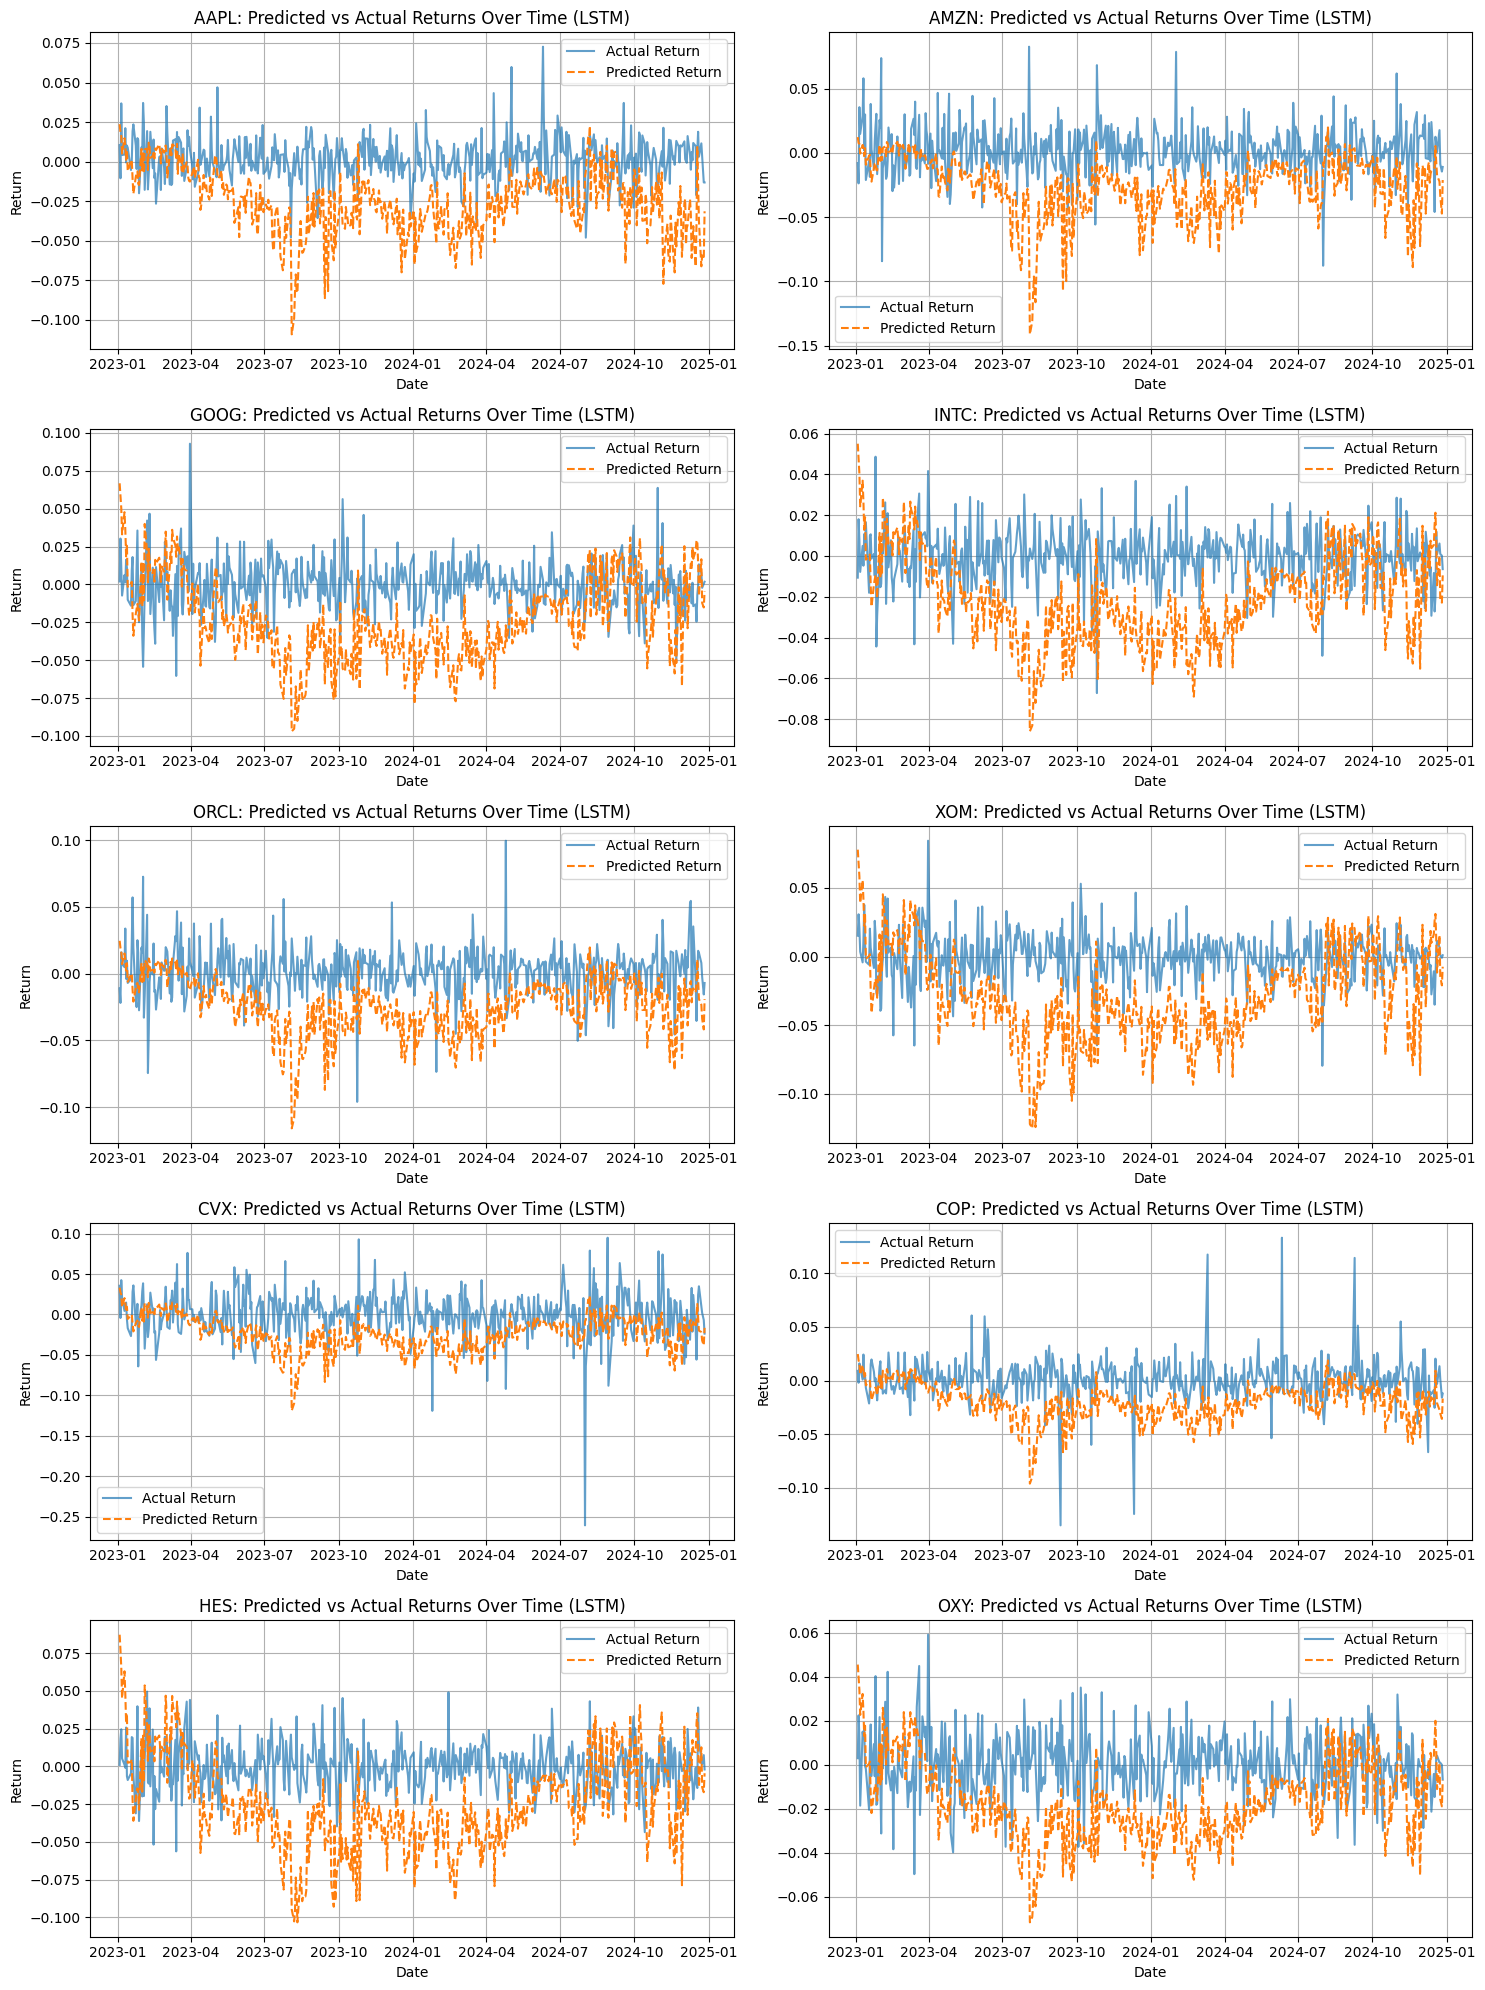

In [105]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, stock in enumerate(Y_train.columns):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax.plot(Y_test_real_df.index, Y_test_real_df[stock], label="Actual Return", alpha=0.7)
    ax.plot(Y_test_real_df.index, predictions_real[:, i], label="Predicted Return", linestyle="--")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    ax.set_title(f"{tickers[i]}: Predicted vs Actual Returns Over Time (LSTM)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()

**Comments:**
- All 3 models fail to make a good prediction on day t+1 return using data upon day t. In fact, due to the noisy nature of stock data, regression is a chanllenging task and it will be more reasonble to conduct a classfication task i.e. predict the sign of the next day's return.
- LSTM and XGBoost have significant performance improvment comparing to Linear Regression.
- The feature engineering step is constrainted by data availability requirement (publicly available), it would be great if we could utilize some paid dataset (eg. https://www.quiverquant.com/home/) which provides information about insider trading, sentiment and popularity of stocks in certain Reddit community, trend score based on Google search, etc. Features extracted from such datasets should enhance our model predictivity.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean returns and covariance matrix
mean_returns = daily_returns_2021.mean()
cov_matrix = daily_returns_2021.cov()

# Number of portfolios to simulate
num_portfolios = 10000

# Store results
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Generate random portfolio weights
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)  # Normalize to sum to 1
    weights_record.append(weights)
    
    # Portfolio return and variance
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    # Store results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = results[0, i] / results[1, i]  # Sharpe Ratio

# Convert to NumPy array for easier manipulation
weights_record = np.array(weights_record)

# Identify Global Minimum Variance Portfolio (GMVP)
min_vol_index = np.argmin(results[1])  # Index of portfolio with minimum volatility
gmvp_weights = weights_record[min_vol_index, :]

# Create a DataFrame for GMVP weights
gmvp_df = pd.DataFrame({'Stock': daily_returns_2021.columns, 'GMVP Weight': gmvp_weights})


# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

# Highlight the GMVP
plt.scatter(results[1, min_vol_index], results[0, min_vol_index], color='red', marker='*', s=200, label='GMVP')

plt.legend()
plt.grid()

gmvp_df.head(10)

NameError: name 'daily_returns_2021' is not defined

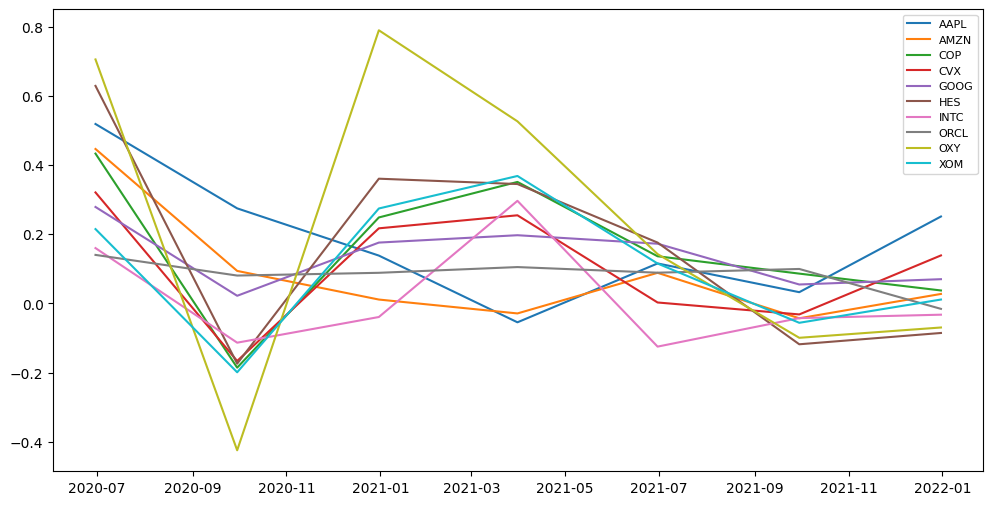

In [ ]:
plt.figure(figsize=(12,6))
for ticker in quarterly_returns.columns:
    plt.plot(quarterly_returns.index, quarterly_returns[ticker], label=ticker)
plt.legend(loc="upper right", fontsize=8)

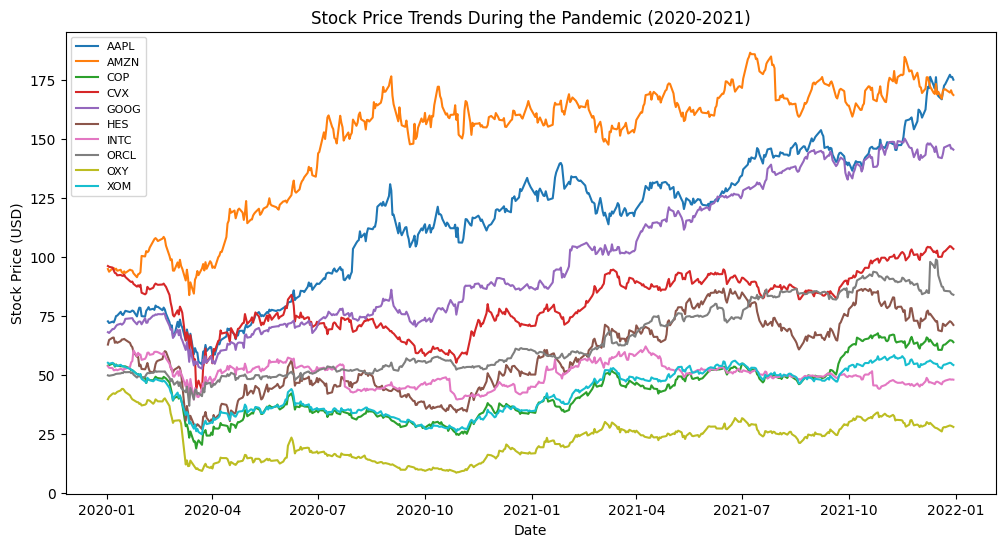

In [ ]:
pandemic_period = data.loc["2020-01-01":"2021-12-31"]

# Plot price trends for the 10 stocks
plt.figure(figsize=(12,6))
for ticker in pandemic_period.columns:
    plt.plot(pandemic_period.index, pandemic_period[ticker], label=ticker)

plt.title("Stock Price Trends During the Pandemic (2020-2021)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend(loc="upper left", fontsize=8)

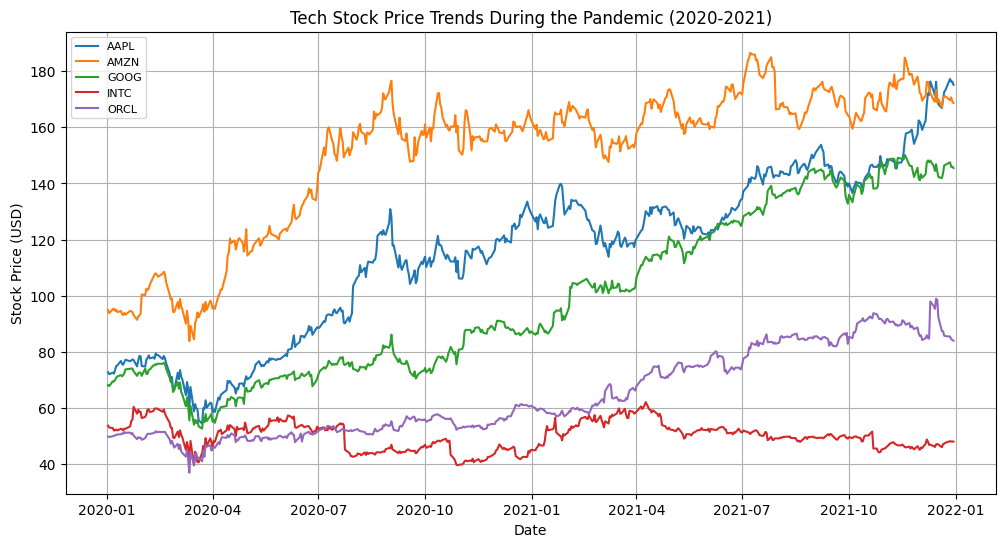

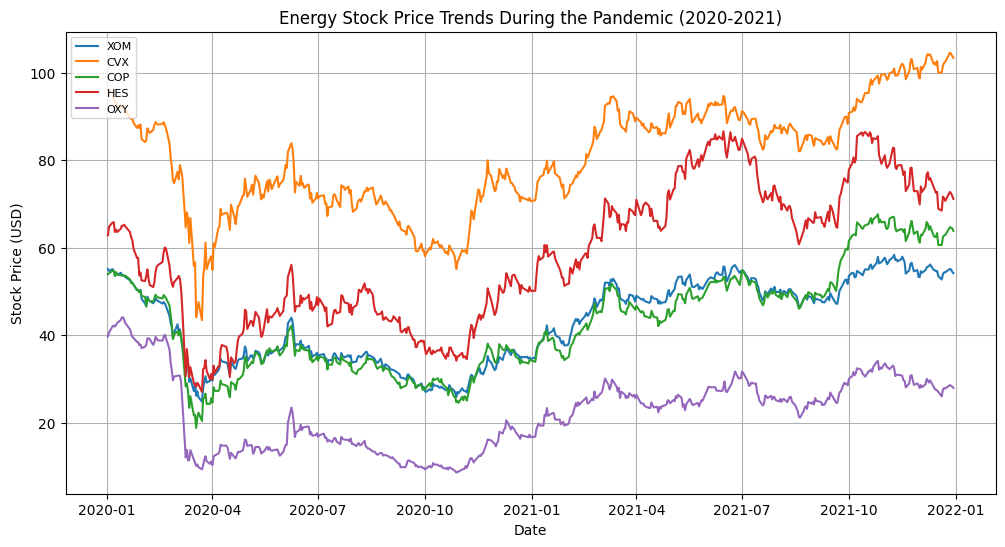

In [ ]:
# Define stock groups
tech_stocks = ["AAPL", "AMZN", "GOOG", "INTC", "ORCL"]
energy_stocks = ["XOM", "CVX", "COP", "HES", "OXY"]

# Plot tech stocks
plt.figure(figsize=(12, 6))
for ticker in tech_stocks:
    plt.plot(pandemic_period.index, pandemic_period[ticker], label=ticker)

plt.title("Tech Stock Price Trends During the Pandemic (2020-2021)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.show()

# Plot energy stocks
plt.figure(figsize=(12, 6))
for ticker in energy_stocks:
    plt.plot(pandemic_period.index, pandemic_period[ticker], label=ticker)

plt.title("Energy Stock Price Trends During the Pandemic (2020-2021)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.show()


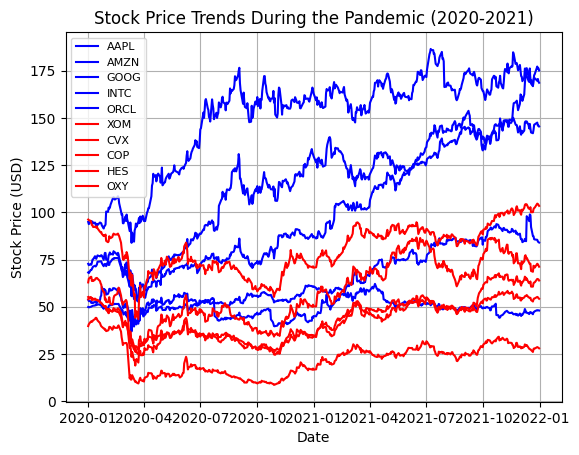

In [ ]:
for ticker in tech_stocks:
    plt.plot(pandemic_period.index, pandemic_period[ticker], label=ticker, color="blue")

# Plot energy stocks in another color
for ticker in energy_stocks:
    plt.plot(pandemic_period.index, pandemic_period[ticker], label=ticker, color="red")

plt.title("Stock Price Trends During the Pandemic (2020-2021)")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)